# Spatial Target Cells

Analyses for if cells care about the spatial target.

Cells of interest:
- 74 looks to be a serial position cell

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import compute_spatial_bin_edges, compute_spatial_bin_assignment
from spiketools.spatial.information import _compute_spatial_information
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions

## Functions

In [5]:
# Note: copied from 01 - consolidate location
def compute_bin_firing(x_binl, y_binl, bins):
    """Compute firing per bin, givin bin assignment of each spike."""
    
    bin_firing = np.zeros(bins)
    for x_bl, y_bl in zip(x_binl, y_binl):
        bin_firing[x_bl - 1, y_bl - 1] += 1
        
    return bin_firing

In [6]:
def compute_serial_position_fr(spikes, trial_starts, chest_openings, ptimes, positions):
    """Collect firing rates per segment across all trials"""

    all_frs = np.zeros([len(trial_starts), 4])
    for t_ind in range(len(trial_starts)):

        t_st = trial_starts[t_ind]
        ch_openings = chest_openings[t_ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == t_ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(spikes, t_st, t_en)

        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))
        inds = count.keys()
        frs = np.array(list(count.values())) / seg_times * 1000

        all_frs[t_ind, :] = frs
        
    return all_frs

In [7]:
def compute_spatial_target_bins(spikes, trial_starts, chest_openings, ptimes, positions, chest_bins):
    """Compute the binned firing rate based on spatial target."""
    
    # Collect firing per chest location across all trials
    target_bins = np.zeros(chest_bins)
    for t_ind in range(len(trial_starts)):

        t_st = trial_starts[t_ind]
        ch_openings = chest_openings[t_ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == t_ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(spikes, t_st, t_en)
        t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))

        frs = np.array(list(count.values())) / seg_times * 1000    

        cur_ch_xbin = ch_xbin[t_mask]
        cur_ch_ybin = ch_ybin[t_mask]

        for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
            target_bins[xbin, ybin] = fr
    
    return target_bins

## Settings

In [8]:
# Set which task to analyze
task = 'THF'

In [9]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/' + task)

In [10]:
# Define subject information
subj = 'wv001'
session = 0

In [11]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]

In [12]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

## Load Data

In [13]:
# Define expected NWB file name & full path
file_name = '_'.join([subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [14]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [11]:
# Get the number of trials & units
n_trials = len(nwbfile.trials)
n_units = len(nwbfile.units)

In [12]:
# Get spikes
uind = 4
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [13]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

In [14]:
# Extract behavioural markers of interest
trial_starts = nwbfile.trials['start_time'].data[:]
chest_openings = nwbfile.trials['chest_opening'].data[:]

In [15]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [16]:
# Get the chest positions & trial indices
chest_xs, chest_ys  = nwbfile.acquisition['chest_positions']['chest_positions'].data[:]
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]

## Chest Positions

In [17]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [18]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


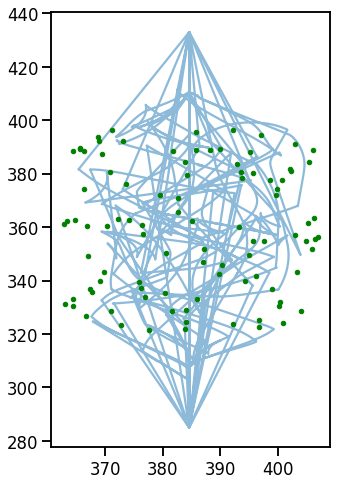

In [19]:
# Plot the chest positions, overlaid with 
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*positions, alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

In [20]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

In [21]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, x_edges, y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1 
ch_ybin = ch_ybin - 1 

## Single Trial

In [22]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['start_time'][t_ind]
ch_openings = nwbfile.trials['chest_opening'][t_ind]
t_en = ch_openings[-1]

In [23]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [24]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [25]:
# Restrict spikes to the 
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

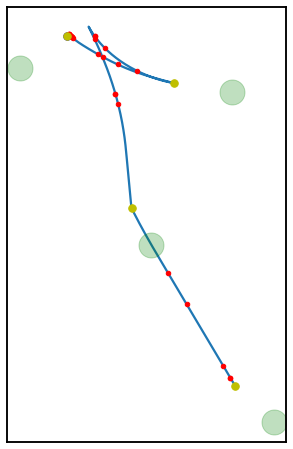

In [26]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
# TODO: add stimulus and event happenings to `plot_positions` & use that here
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*t_pos)
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

## Serial Position

In [27]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [28]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
inds = count.keys()
frs = np.array(list(count.values())) / seg_times * 1000

<BarContainer object of 4 artists>

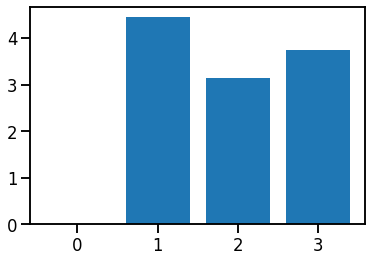

In [29]:
# Plot firing rate per segment (single trial)
plt.bar(inds, frs)

In [30]:
# Compute firing rates per segment across all trials
all_frs = compute_serial_position_fr(spikes, trial_starts, chest_openings, ptimes, positions)

<BarContainer object of 4 artists>

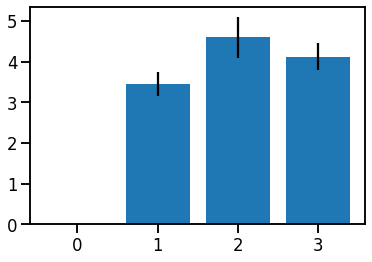

In [32]:
# Plot firing rates per segment across all trials
plt.bar(inds, all_frs.mean(0), yerr=sem(all_frs, 0))

## Spatial Target Bins

In [33]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [34]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(\
    np.min(chest_occupancy), np.max(chest_occupancy)))

Range of chests per bin: 0 - 6


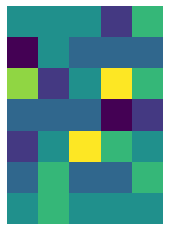

In [35]:
# Plot chest occupancy
plot_heatmap(chest_occupancy, transpose=True)

In [36]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, trial_starts, chest_openings, ptimes, positions, chest_bins)

In [38]:
# Check range of firing across spatial target bins
np.min(target_bins), np.max(target_bins)

(0.0, 7.457186651824171)

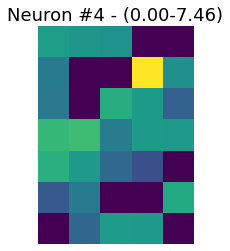

In [39]:
# Check the firing rate per spatial destination for an example neuron
plot_heatmap(target_bins, transpose=True,
             title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, np.min(target_bins), np.max(target_bins)))

#### Spatial Information

In [40]:
# ...
spike_info = _compute_spatial_information(target_bins, chest_occupancy)
print(spike_info)

0.5542051226428903


In [41]:
# Create shuffled time series for comparison
#   Note: some temporary quirks here to deal with UNIX time
temp = spikes - st
times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
times_shuffle = times_shuffle + st

In [42]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    
    target_bins = compute_spatial_target_bins(stimes, trial_starts, chest_openings,
                                              ptimes, positions, chest_bins)         
    surrs[ind] = _compute_spatial_information(target_bins, chest_occupancy)

In [43]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(spike_info, surrs)

# Compute z-score of spatial information compared to surrogates
z_score = zscore_to_surrogates(spike_info, surrs)

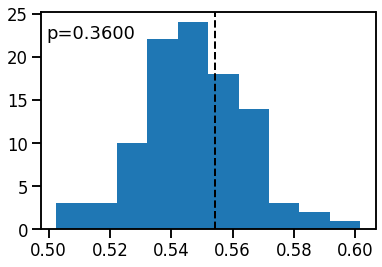

In [44]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, spike_info, surr_p_val)

## All Cells

failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run
failed to run


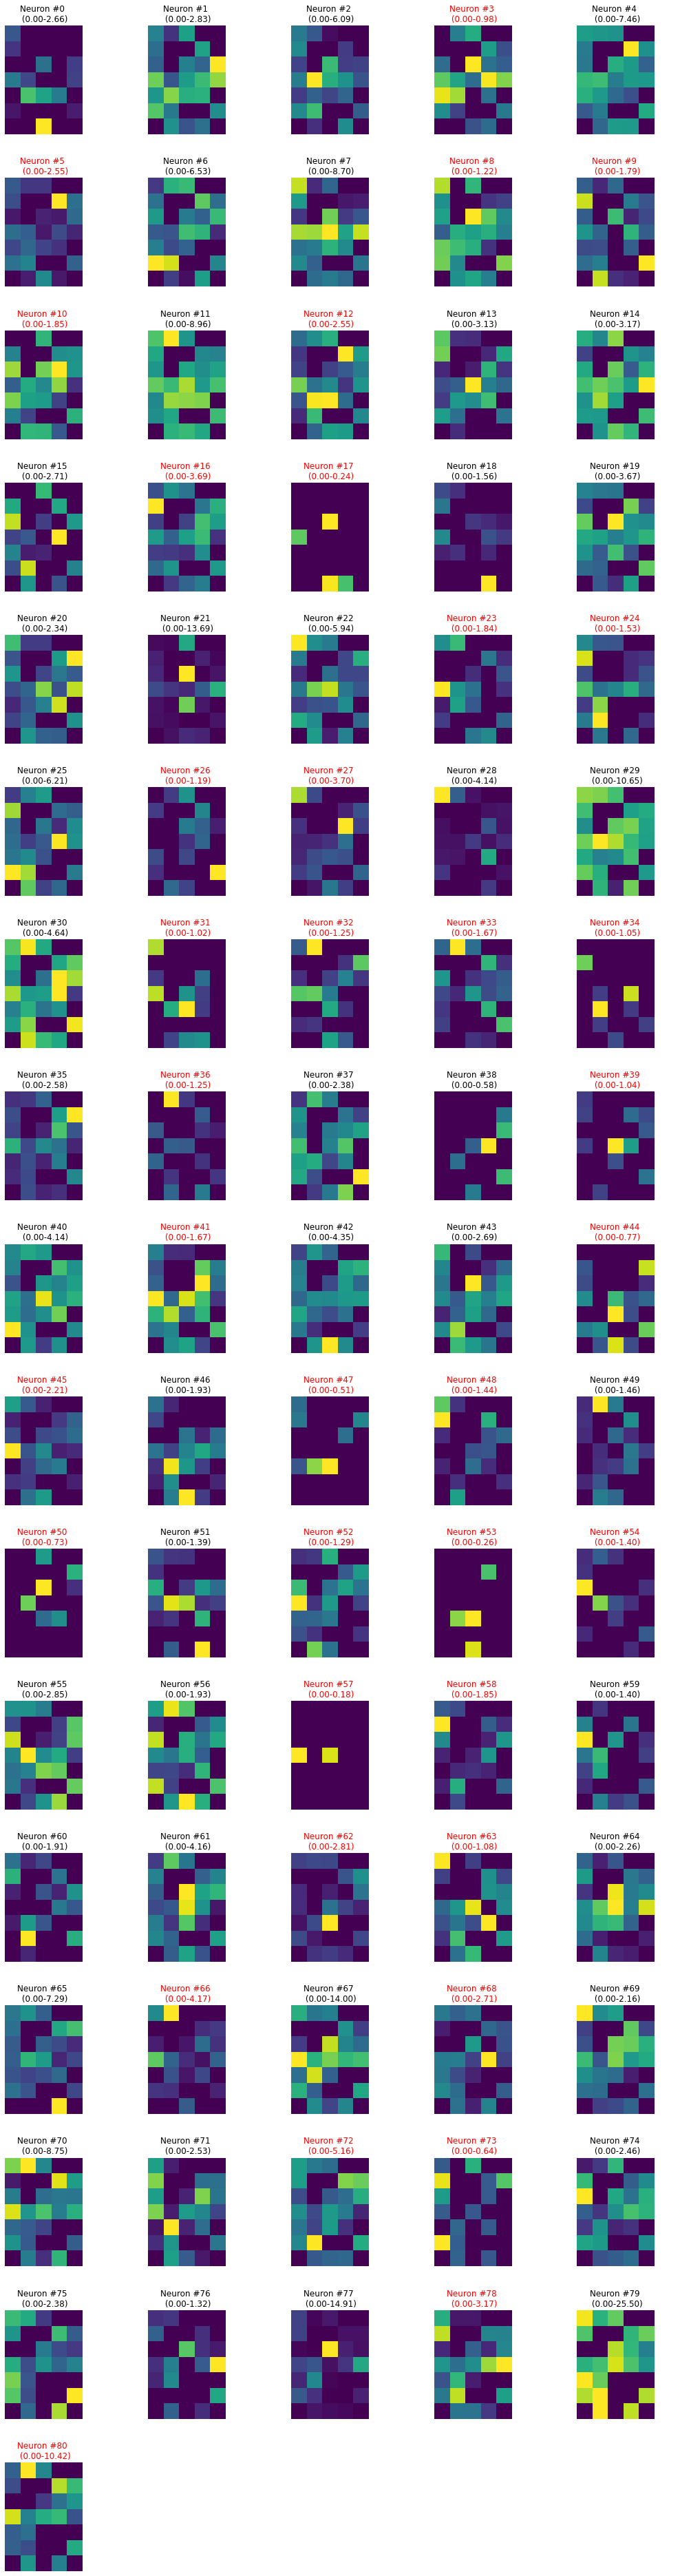

In [58]:
# Plot spatial target heat maps for all cells
for ii, ax in zip(range(n_units), make_axes(n_units, hspace=0.4)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii) / 1000

    # ...
    target_bins = compute_spatial_target_bins(spikes, trial_starts, chest_openings,
                                              ptimes, positions, chest_bins)
    spike_info = _compute_spatial_information(target_bins, chest_occupancy)
            
    # Create shuffled time series for comparison
    #   Note: some temporary quirks here to deal with UNIX time
    try:
        temp = spikes - st
        times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
        times_shuffle = times_shuffle + st
    
        # Compute spatial information measures on surrogates
        surrs = np.zeros(n_surrogates)
        for ind, stimes in enumerate(times_shuffle):
            
            target_bins = compute_spatial_target_bins(stimes, trial_starts, chest_openings,
                                                      ptimes, positions, chest_bins)
            surrs[ind] = _compute_spatial_information(target_bins, chest_occupancy)
            
        # Compute the empirical p-value based on surrogates
        surr_p_val = compute_empirical_pvalue(spike_info, surrs)

        # Compute z-score of spatial information compared to surrogates
        z_score = zscore_to_surrogates(spike_info, surrs)
            
    except:
        print('failed to run')
        surr_p_val = 1
    
    color = 'red' if surr_p_val < 0.5 else 'black'
    #color = 'black'

    plot_heatmap(target_bins, transpose=True, ax=ax)   
    ax.set_title('Neuron #{} \n ({:1.2f}-{:1.2f})'.format(ii, np.min(target_bins), np.max(target_bins)), 
                 fontdict={'fontsize' : 12}, color=color);